# **Método de la Interpolación Cuadrática**
Isaac Esteban Uribe Jaramillo


## **1. Importamos librerías**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Widgets para permitir elegir minimización o maximización (opcional en Colab)
try:
    import ipywidgets as widgets
    from IPython.display import display
except Exception:
    widgets = None

## **2. Inicialización y pre-procesamiento**

### 2.1 Definimos la función y su gráfica

In [3]:
fx = lambda x: 2*np.sin(x) - (x**2 / 10)

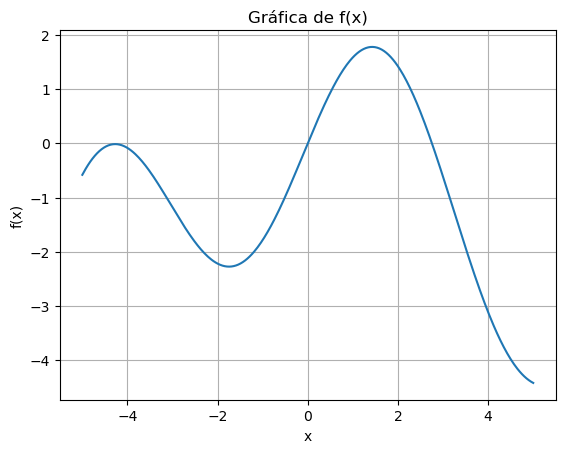

In [4]:
# Gráfica base de f(x)
x = np.linspace(-5, 5, 400)
y = fx(x)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gráfica de f(x)')
plt.grid(True)
plt.show()

### 2.2 Seleccionamos valores iniciales para Xl, Xu, Err

In [19]:
# Valores iniciales y tolerancia
x0, x1, x2 = 0.0, 1.0, 4.0
err = 1e-4  # tolerancia

# Selector de modo (minimizar / maximizar)
modo = 'minimizar'  # valor por defecto
if 'widgets' in globals() and widgets is not None:
    modo_selector = widgets.ToggleButtons(options=['minimizar','maximizar'], description='Modo:')
    display(modo_selector)
    def _get_modo(change=None):
        global modo
        modo = modo_selector.value
    _get_modo()
    modo_selector.observe(_get_modo, names='value')
else:
    # Fallback para entornos sin widgets
    try:
        _inp = input("Escribe 'minimizar' o 'maximizar' (por defecto: minimizar): ").strip().lower()
        if _inp in ('minimizar','maximizar'):
            modo = _inp
    except Exception:
        pass

# Aseguremos el orden x0 < x1 < x2
xs = sorted([x0, x1, x2])
x0, x1, x2 = xs[0], xs[1], xs[2]


ToggleButtons(description='Modo:', options=('minimizar', 'maximizar'), value='minimizar')

### 2.3 Inicializamos el Dataframe

In [27]:
df = []

### 2.4 Determinamos cuantas iteraciones necesitamos para llegar a la convergencia

In [28]:
def iteracionesMaximas(xl,xu,err):
  return int(np.log2((xu - xl) / err) - 1)

## **3. Algorítmo de la Interpolación cuadrática**

In [29]:
def interpolacionCuadratica(fx, x0, x1, x2, err, mode='minimizar', max_iter=100):
    """
    Interpolación cuadrática con opción de minimizar o maximizar.
    Criterio de parada: |error_k - error_{k-1}| < err  ó  |x3 - x1| < err.
    Devuelve: x_opt, DataFrame de resultados
    """
    # Limpiamos cualquier corrido previo
    try:
        df.clear()
    except NameError:
        pass

    # Asegurar orden por x
    x0, x1, x2 = sorted([x0, x1, x2])
    # Comparador según el modo
    comp = (lambda a, b: a < b) if mode == 'minimizar' else (lambda a, b: a > b)

    prev_err_main = None
    prev_x3 = None

    for k in range(1, max_iter + 1):
        f0, f1, f2 = fx(x0), fx(x1), fx(x2)

        denom = (f0 * (x1 - x2) + f1 * (x2 - x0) + f2 * (x0 - x1))
        if denom == 0:
            x3 = x1
        else:
            x3 = 0.5 * (
                f0 * (x1**2 - x2**2) +
                f1 * (x2**2 - x0**2) +
                f2 * (x0**2 - x1**2)
            ) / denom
        f3 = fx(x3)

        # Errores solicitados
        err_intervalo = abs(x0 - x2)              # como en el cuaderno original
        err_vs_x1 = abs(x3 - x1)                  # nuevo
        err_vs_x2 = abs(x3 - x2)                  # nuevo
        err_vs_x0 = abs(x3 - x0)                  # (útil como referencia)
        err_vs_prev_x3 = (abs(x3 - prev_x3) if prev_x3 is not None else float('nan'))  # nuevo
        err_main = err_vs_x1  # usaremos este como error principal

        # Guardamos fila
        df.append([
            k, x0, x1, x2, x3, f0, f1, f2, f3,
            err_intervalo, err_vs_x1, err_vs_x2, err_vs_x0, err_vs_prev_x3, mode
        ])

        # Criterios de parada
        if prev_err_main is not None and abs(err_main - prev_err_main) < err:
            break
        if err_main < err:
            break

        # Actualización del trío dependiendo del modo
        if x3 < x1:
            if comp(f3, f1):
                # x3 es mejor que x1 y queda al lado izquierdo
                x2 = x1
                x1 = x3
            else:
                # x1 sigue siendo mejor, corremos x0 hacia x3
                x0 = x3
        else:  # x3 >= x1
            if comp(f3, f1):
                # x3 es mejor que x1 y queda al lado derecho
                x0 = x1
                x1 = x3
            else:
                # x1 sigue siendo mejor, corremos x2 hacia x3
                x2 = x3

        prev_err_main = err_main
        prev_x3 = x3

    # DataFrame de resultados
    cols = ['Iteración','x0','x1','x2','x3','f(x0)','f(x1)','f(x2)','f(x3)',
            'Error','Err_vs_x1','Err_vs_x2','Err_vs_x0','Err_vs_prev_x3','Modo']
    resultados = pd.DataFrame(df, columns=cols).set_index('Iteración')
    # x óptimo según modo (mejor x1 de la última iteración)
    x_opt = resultados.iloc[-1]['x1'] if len(resultados) else x1
    return x_opt, resultados


## **4. Obtención de resultados**

In [30]:
# Ejecutar el algoritmo
x_opt, results = interpolacionCuadratica(fx, x0, x1, x2, err, mode=modo)

# Mostrar la tabla completa
results

,x0,x1,x2,x3,f(x0),f(x1),f(x2),f(x3),Error,Err_vs_x1,Err_vs_x2,Err_vs_x0,Err_vs_prev_x3,Modo
Iteración,,,,,,,,,,,,,,
1,0.000000,1.000000,4.000000,1.505535,0.000000,1.582942,-3.113605,1.769079,4.000000,0.505535,2.494465,1.505535,NaN,maximizar
2,1.000000,1.505535,4.000000,1.490253,1.582942,1.769079,-3.113605,1.771431,3.000000,0.015282,2.509747,0.490253,0.015282,maximizar
3,1.000000,1.490253,1.505535,1.425636,1.582942,1.771431,1.769079,1.775722,0.505535,0.064617,0.079899,0.425636,0.064617,maximizar
4,1.000000,1.425636,1.490253,1.426602,1.582942,1.775722,1.771431,1.775725,0.490253,0.000966,0.063651,0.426602,0.000966,maximizar
5,1.425636,1.426602,1.490253,1.427548,1.775722,1.775725,1.771431,1.775726,0.064617,0.000947,0.062704,0.001912,0.000947,maximizar


In [31]:
# (Opcional) Resumen final
print(f"Modo: {modo}. x* ≈ {x_opt:.6f}")
results.tail(5)

Modo: maximizar. x* ≈ 1.426602


,x0,x1,x2,x3,f(x0),f(x1),f(x2),f(x3),Error,Err_vs_x1,Err_vs_x2,Err_vs_x0,Err_vs_prev_x3,Modo
Iteración,,,,,,,,,,,,,,
1,0.000000,1.000000,4.000000,1.505535,0.000000,1.582942,-3.113605,1.769079,4.000000,0.505535,2.494465,1.505535,NaN,maximizar
2,1.000000,1.505535,4.000000,1.490253,1.582942,1.769079,-3.113605,1.771431,3.000000,0.015282,2.509747,0.490253,0.015282,maximizar
3,1.000000,1.490253,1.505535,1.425636,1.582942,1.771431,1.769079,1.775722,0.505535,0.064617,0.079899,0.425636,0.064617,maximizar
4,1.000000,1.425636,1.490253,1.426602,1.582942,1.775722,1.771431,1.775725,0.490253,0.000966,0.063651,0.426602,0.000966,maximizar
5,1.425636,1.426602,1.490253,1.427548,1.775722,1.775725,1.771431,1.775726,0.064617,0.000947,0.062704,0.001912,0.000947,maximizar


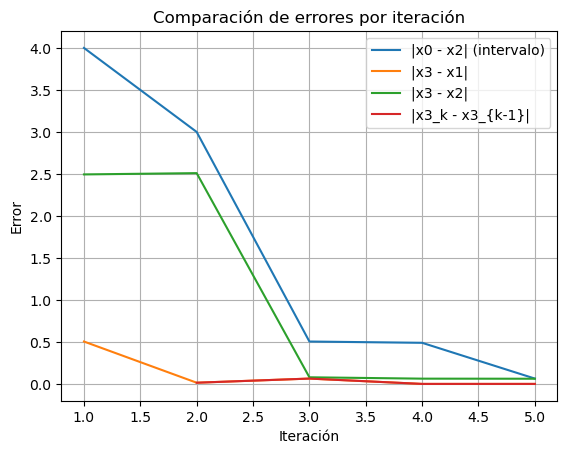

In [32]:
# Gráficas de error por iteración (comparaciones solicitadas)
plt.plot(results.index, results['Error'], label='|x0 - x2| (intervalo)')
plt.plot(results.index, results['Err_vs_x1'], label='|x3 - x1|')
plt.plot(results.index, results['Err_vs_x2'], label='|x3 - x2|')
plt.plot(results.index, results['Err_vs_prev_x3'], label='|x3_k - x3_{k-1}|')
plt.xlabel('Iteración')
plt.ylabel('Error')
plt.title('Comparación de errores por iteración')
plt.grid(True)
plt.legend()
plt.show()


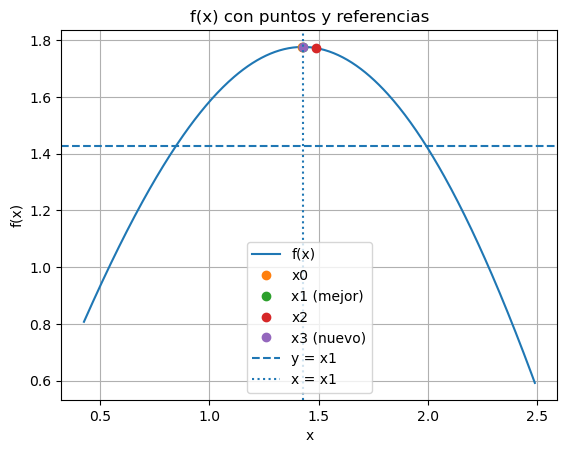

In [33]:
# Gráfica de f(x) con puntos (x0, x1, x2, x3) y línea horizontal y = x1
# Tomamos la última iteración para dibujar
last = results.iloc[-1]
x0_g, x1_g, x2_g, x3_g = last['x0'], last['x1'], last['x2'], last['x3']

x = np.linspace(min(x0_g, x1_g, x2_g)-1, max(x0_g, x1_g, x2_g)+1, 400)
y = fx(x)
plt.plot(x, y, label='f(x)')

plt.plot([x0_g], [fx(x0_g)], 'o', label='x0')
plt.plot([x1_g], [fx(x1_g)], 'o', label='x1 (mejor)')
plt.plot([x2_g], [fx(x2_g)], 'o', label='x2')
plt.plot([x3_g], [fx(x3_g)], 'o', label='x3 (nuevo)')

# Línea horizontal solicitada: y = x1
plt.axhline(y=x1_g, linestyle='--', label='y = x1')

# (Opcional) línea vertical en x = x1 como referencia
plt.axvline(x=x1_g, linestyle=':', label='x = x1')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('f(x) con puntos y referencias')
plt.grid(True)
plt.legend()
plt.show()


In [34]:
import matplotlib.animation as animation

# ======================
# Animación paso a paso
# ======================

# Tomamos todos los estados de x0, x1, x2, x3
iteraciones = results.index.values
x_vals = np.linspace(min(results[['x0','x1','x2','x3']].min()) - 1,
                     max(results[['x0','x1','x2','x3']].max()) + 1, 400)
y_vals = fx(x_vals)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_vals, y_vals, 'b-', label='f(x)')
line_x0, = ax.plot([], [], 'ro', label='x0')
line_x1, = ax.plot([], [], 'go', label='x1')
line_x2, = ax.plot([], [], 'mo', label='x2')
line_x3, = ax.plot([], [], 'ko', label='x3')

# Línea horizontal y = x1 y vertical x = x1 en cada frame
hline = ax.axhline(y=0, color='gray', linestyle='--', lw=0.8)
vline = ax.axvline(x=0, color='gray', linestyle=':', lw=0.8)

ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title(f"Evolución de la {modo}")
ax.legend()
ax.grid(True)

def init():
    line_x0.set_data([], [])
    line_x1.set_data([], [])
    line_x2.set_data([], [])
    line_x3.set_data([], [])
    hline.set_ydata([0])
    vline.set_xdata([0])
    return line_x0, line_x1, line_x2, line_x3, hline, vline

def update(i):
    row = results.iloc[i]
    x0_g, x1_g, x2_g, x3_g = row['x0'], row['x1'], row['x2'], row['x3']
    line_x0.set_data([x0_g], [fx(x0_g)])
    line_x1.set_data([x1_g], [fx(x1_g)])
    line_x2.set_data([x2_g], [fx(x2_g)])
    line_x3.set_data([x3_g], [fx(x3_g)])
    hline.set_ydata([x1_g])  # línea horizontal en y = x1
    vline.set_xdata([x1_g])  # línea vertical en x = x1
    ax.set_title(f"Iteración {row.name} – {modo}, x1={x1_g:.4f}")
    return line_x0, line_x1, line_x2, line_x3, hline, vline

ani = animation.FuncAnimation(fig, update, frames=len(results),
                              init_func=init, blit=True, repeat=False)

plt.close(fig)  # Para no mostrar estática la figura
from IPython.display import HTML
HTML(ani.to_jshtml())
